In [1]:
import os
import sqlite3
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer
from config import CFG
from CLIP import CLIPModel
import torch
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, use_pillow=True):
        self.image_paths = [os.path.join(root_dir, file) for file in os.listdir(root_dir) if file.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))]
        self.transform = transform
        self.use_pillow = use_pillow

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        if self.use_pillow:
            image = Image.open(img_path).convert('RGB')
            image = np.array(image) 
        else:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        if self.transform:
            transformed = self.transform(image=image) 
            image = transformed['image']

        image_tensor = torch.tensor(image).permute(2, 0, 1).float()
        
        return {'image': image_tensor, 'filename': os.path.basename(img_path)}

def get_transforms():
    return A.Compose([
        A.Resize(CFG.size, CFG.size, always_apply=True),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True),
        A.HorizontalFlip(),
    ])

def load_model(model_path, device):
    model = CLIPModel().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model_image_embedding=CLIPModel().image_encoder.to(device)
    model.eval()
    model_image_embedding.eval()

    return model, model_image_embedding

def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    filenames = []
    embedding_faiss=[]
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting embeddings"):
            images = batch['image'].to(device)
            batch_filenames = batch['filename']


            image_features = model.image_encoder(images)
            #EMBEDDING FAISS
            embedding_faiss.append(image_features.cpu().numpy())
            # EMBEDDING CLIP
            image_embeddings = model.image_projection(image_features)
        
            embeddings.append(image_embeddings.cpu().numpy())
            filenames.extend(batch_filenames)

    embeddings = np.vstack(embeddings)
    embedding_faiss=np.vstack(embedding_faiss)
    return embeddings, filenames, embedding_faiss

def create_database(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS image_embeddings (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            filename TEXT UNIQUE,
            embedding BLOB
        )
    ''')
    conn.commit()
    conn.close()

def save_embeddings_to_db(db_path, filenames, embeddings):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    for filename, embedding in zip(filenames, embeddings):
        embedding_blob = embedding.tobytes()
        try:
            cursor.execute('''
                INSERT OR IGNORE INTO image_embeddings (filename, embedding)
                VALUES (?, ?)
            ''', (filename, embedding_blob))
        except Exception as e:
            print(f"Error inserting {filename}: {e}")

    conn.commit()
    conn.close()   
    

def load_embeddings_from_db(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    cursor.execute('SELECT filename, embedding FROM image_embeddings')
    data = cursor.fetchall()
    conn.close()
    
    if not data:  # Nếu không có dữ liệu trong database
        return [], np.array([])  # Trả về danh sách rỗng và mảng rỗng
    
    filenames = [item[0] for item in data]
    embeddings = [np.frombuffer(item[1], dtype=np.float32) for item in data]
    
    return filenames, np.stack(embeddings)


### FAISS
def create_faiss_database(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS faiss_embeddings (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            image_path TEXT NOT NULL,
            embedding BLOB NOT NULL
        )
    """)
    conn.commit()
    conn.close()
    
def save_faiss_embeddings_to_db(db_path, filenames, embeddings):
    """
    Lưu embeddings và đường dẫn ảnh vào SQLite.
    """
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS image_faiss_embeddings (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            image_path TEXT UNIQUE,
            embedding BLOB
        )
    ''')
    
    for filename, embedding in zip(filenames, embeddings):
        image_path = os.path.join(CFG.image_path, filename)
        embedding_blob = sqlite3.Binary(embedding.tobytes())
        try:
            cursor.execute('''
                INSERT OR IGNORE INTO faiss_embeddings (image_path, embedding)
                VALUES (?, ?)
            ''', (image_path, embedding_blob))
        except Exception as e:
            print(f"Error inserting {filename}: {e}")
    conn.commit()
    conn.close()
    

def load_embeddings_faiss_from_db(db_path):
    """
    Tải tất cả embeddings và metadata từ SQLite.
    """
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    cursor.execute("SELECT image_path, embedding FROM faiss_embeddings")
    results = cursor.fetchall()
    conn.close()

    image_paths = []
    embeddings = []

    for row in results:
        image_paths.append(row[0])
        # Chuyển đổi BLOB thành numpy array
        embedding = np.frombuffer(row[1], dtype=np.float32)
        embeddings.append(embedding)

    return np.array(embeddings), image_paths

    

def get_new_images(image_path, db_filenames):
    all_images = [os.path.basename(file) for file in os.listdir(image_path) if file.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))]
    new_images = [img for img in all_images if img not in db_filenames]
    return new_images

def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query], padding=True, truncation=True, max_length=CFG.max_length, return_tensors="pt")
    batch = {
        key: values.to(CFG.device)
        for key, values in encoded_query.items()
    }

    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n)
    matches = [image_filenames[idx] for idx in indices]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(os.path.join(CFG.image_path, match))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        print(image.shape)
        ax.imshow(image)
        ax.axis("off")

    plt.show()
    
def find_matches_for_faiss(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query], padding=True, truncation=True, max_length=CFG.max_length, return_tensors="pt")
    batch = {
        key: values.to(CFG.device)
        for key, values in encoded_query.items()
    }

    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n)
    matches = [image_filenames[idx] for idx in indices]

    list_images_matches=[]
    for match  in matches:
        image =os.path.join(CFG.image_path, match)
        list_images_matches.append(image)

    return list_images_matches
        
# Main logic
db_path = 'image_embeddings.db'
create_database(db_path)
create_faiss_database(db_path)

# Load filenames and embeddings from the database
db_filenames, db_embeddings = load_embeddings_from_db(db_path)
db_faiss_filenames, db_faiss_embeddings = load_embeddings_faiss_from_db(db_path)
image_path = r"E:\NLP\ImageRetrieval\UIT-ViLC\dataset\test\images"
# Nếu không có embeddings trong database
if db_embeddings.size == 0:
    print("Database is empty. Processing all images...")
    transforms = get_transforms()
    dataset = ImageDataset(image_path, transforms)
    dataloader = DataLoader(dataset, batch_size=CFG.batch_size, shuffle=False)

    model, _ = load_model(r"E:\NLP\ImageRetrieval\Final\uit-vilc-swin-b.pt", CFG.device)
    all_embeddings, all_filenames, all_embedding_faiss = extract_embeddings(model, dataloader, CFG.device)

    # Lưu tất cả ảnh vào database
    save_embeddings_to_db(db_path, all_filenames, all_embeddings)
    save_faiss_embeddings_to_db(db_path, all_filenames, all_embedding_faiss)
    print(f"All images processed and saved to database: {len(all_filenames)} images.")
else:
    # Xác định ảnh mới
    print("Loading existing data from database...")
    new_images = get_new_images(image_path, db_filenames)

    if new_images:
        print(f"Found {len(new_images)} new images. Processing...")
        transforms = get_transforms()
        dataset = ImageDataset(CFG.image_path, transforms)
        dataloader = DataLoader(dataset, batch_size=CFG.batch_size, shuffle=False)

        model, _ = load_model(r"E:\NLP\ImageRetrieval\Final\uit-vilc-swin-b.pt", CFG.device)
        new_embeddings, new_filenames, new_embedding_faiss = extract_embeddings(model, dataloader, CFG.device)

        # Lưu ảnh mới vào database
        save_embeddings_to_db(db_path, new_filenames, new_embeddings)
        save_faiss_embeddings_to_db(db_path, new_filenames, new_embedding_faiss)
        print(f"Processed and saved {len(new_filenames)} new images to database.")
    else:
        print("No new images found. Database is up to date.")

# Nạp lại toàn bộ dữ liệu từ database
all_filenames, all_embeddings = load_embeddings_from_db(db_path)
all_faiss_filenames, all_faiss_embeddings = load_embeddings_faiss_from_db(db_path)

#Truy vấn và hiển thị kết quả
# model, _ = load_model(r"E:\NLP\ImageRetrieval\Final\uit-vilc-swin-b.pt", CFG.device)
# find_matches(
#     model,
#     torch.tensor(all_embeddings),
#     query="Vận động viên tennis nữ đang bước tới vung vợt đỡ bóng",
#     image_filenames=all_filenames,
#     n=9
# )

Database is empty. Processing all images...


Some weights of RobertaModel were not initialized from the model checkpoint at phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Extracting embeddings: 100%|██████████| 3/3 [01:31<00:00, 30.43s/it]

All images processed and saved to database: 232 images.


In [2]:
def build_faiss_index_with_hnsw(embeddings, d, m=32, ef_construction=40):
    """
    Xây dựng FAISS index dựa trên HNSW (Proximity Graph-Based).
    """
    index = faiss.IndexHNSWFlat(d, m)  # HNSW với m neighbors
    index.hnsw.efConstruction = ef_construction  # Tăng tốc độ tìm kiếm
    index.add(embeddings)
    return index

def build_faiss_index_with_kmeans(embeddings, d, nlist=100):
    """
    Xây dựng FAISS index dựa trên Lloyd's KMeans.
    """
    quantizer = faiss.IndexFlatL2(d)  # Sử dụng chỉ số cơ bản L2
    index = faiss.IndexIVFFlat(quantizer, d, nlist)  # KMeans-based index
    index.train(embeddings)  # Cần huấn luyện trước khi add dữ liệu
    index.add(embeddings)
    return index

def build_faiss_index_with_small_k(embeddings):
    """
    Xây dựng FAISS index dựa trên Small-k-selection.
    """
    d = embeddings.shape[1]
    index = faiss.IndexFlatL2(d)  # Small-k-selection sử dụng Flat L2
    index.add(embeddings)
    return index


def query_similar_images(query_embedding, db_path="embeddings.db", state=1, k=5):
    """
    Truy vấn hình ảnh gần nhất từ SQLite với FAISS, sử dụng các phương pháp khác nhau.
    
    Parameters:
        query_embedding (np.ndarray): Embedding của ảnh truy vấn.
        db_path (str): Đường dẫn tới SQLite database chứa embeddings.
        state (int): Phương pháp truy vấn.
                     1 = KNN (Flat Index)
                     2 = Proximity Graph-Based (HNSW)
                     3 = Lloyd's KMeans
                     4 = Small-k-selection
        k (int): Số lượng kết quả cần truy vấn.
        
    Returns:
        list: Danh sách tuple chứa đường dẫn ảnh và khoảng cách tương ứng.
    """
    # Load embeddings và image_paths từ database
    embeddings, image_paths = load_embeddings_faiss_from_db(db_path)
    d = embeddings.shape[1]  # Kích thước của embedding


    # Chọn phương pháp xây dựng index dựa trên state
    if state == 1:
        # KNN (Flat Index)
        index = faiss.IndexFlatL2(d)
        index.add(embeddings)
    elif state == 2:
        # Proximity Graph-Based (HNSW)
        index = build_faiss_index_with_hnsw(embeddings, d)
    elif state == 3:
        # Lloyd's KMeans
        index = build_faiss_index_with_kmeans(embeddings, d)
    elif state == 4:
        # Small-k-selection
        index = build_faiss_index_with_small_k(embeddings)
    else:
        raise ValueError("Invalid state. Must be 1 (KNN), 2 (HNSW), 3 (KMeans), or 4 (Small-k-selection).")

    # Tìm kiếm k ảnh gần nhất
    D, I = index.search(query_embedding, k)
    

    # Trả về kết quả dưới dạng danh sách (đường dẫn ảnh, khoảng cách)
    results = [(image_paths[i], D[0][j]) for j, i in enumerate(I[0])]
    return results

Some weights of RobertaModel were not initialized from the model checkpoint at phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


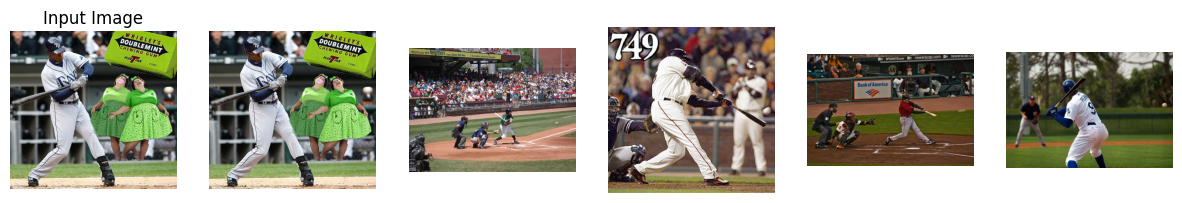

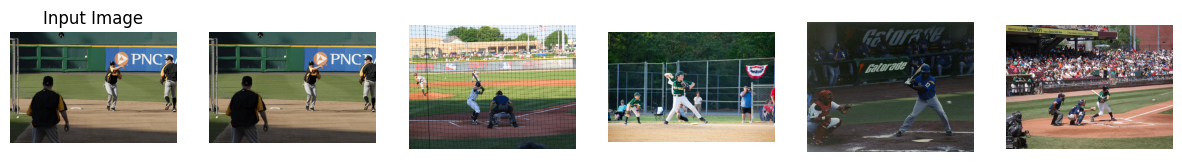

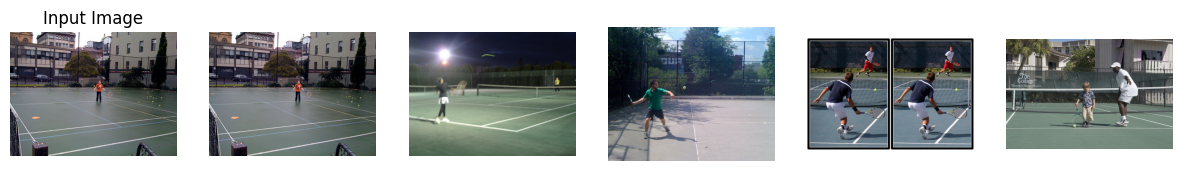

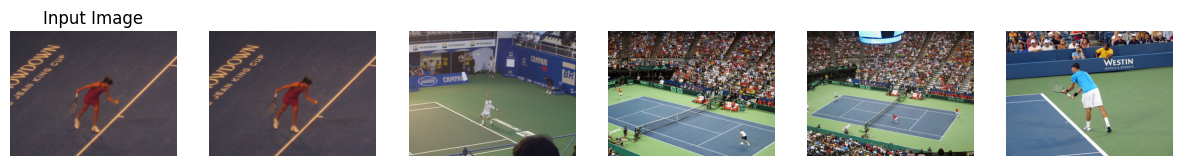

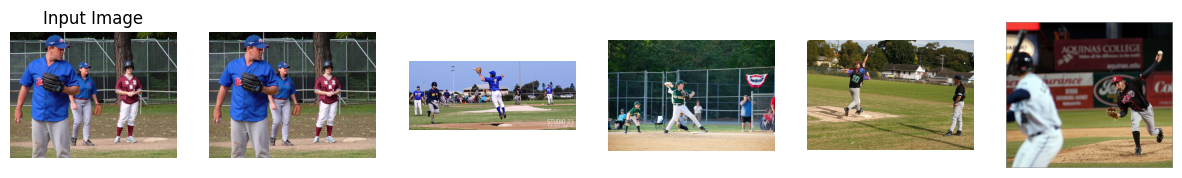

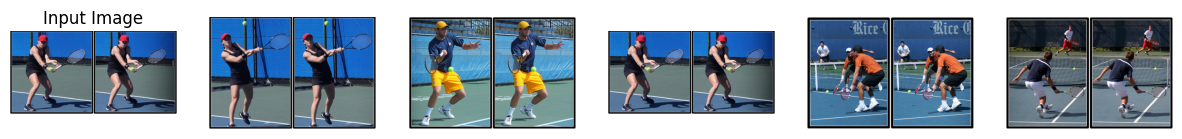

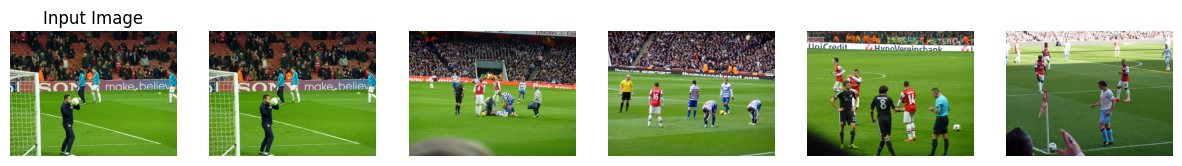

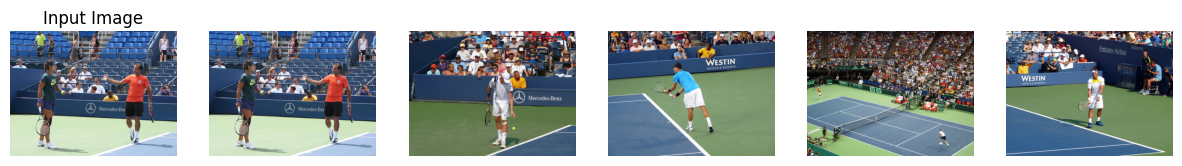

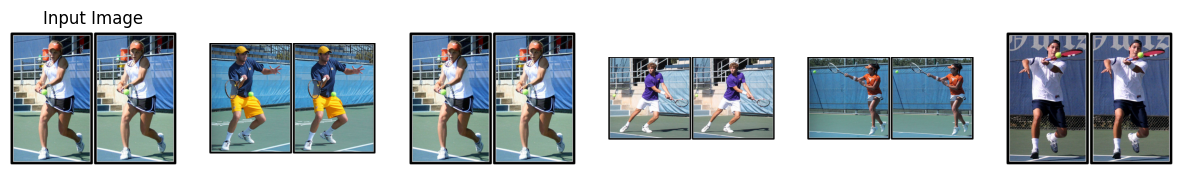

In [3]:
import os
import numpy as np
import faiss
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import Dataset
import ipywidgets as widgets
from IPython.display import display

def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for inputs, labels_batch in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            embeddings.append(outputs.cpu().numpy())
            labels.append(labels_batch.numpy())

    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)

    return embeddings, labels
    

def load_faiss(fvecs_path, dim=1280):
    fvecs = np.memmap(fvecs_path, dtype='float32', mode='r').view('float32').reshape(-1, dim)
    return fvecs

def build_faiss_index(embeddings):
    d = embeddings.shape[1]
    index = faiss.IndexFlatL2(d)  # L2 거리 메트릭 사용
    index.add(embeddings)
    return index

def search_faiss_index(query_embedding, index, k=5):
    D, I = index.search(query_embedding, k)
    return D, I

# def load_model(model, model_path):
#     model.load_state_dict(torch.load(model_path,map_location="cpu"))
#     return model

def show_image_with_label(image_path, label):
    image = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

def show_images_with_labels(image_paths, labels):
    num_images = len(image_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        image = Image.open(image_paths[i])
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {labels[i]}')
        axes[i].axis('off')

    plt.show()

def show_input_and_related_images(input_image_path, related_image_paths, ):
    num_images = len(related_image_paths) + 1

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    input_image = Image.open(input_image_path)
    axes[0].imshow(input_image)
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    # 연관 이미지 표시
    for i in range(1, num_images):
        related_image = Image.open(related_image_paths[i - 1])
        axes[i].imshow(related_image)
        axes[i].axis('off')

    plt.show()

def get_all_image_paths(root_dir):

    supported_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    image_paths = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in supported_extensions):
                full_path = os.path.join(subdir, file)
                image_paths.append(full_path)

    return image_paths

def main():

    model_path = r"E:\NLP\ImageRetrieval\Final\uit-vilc-swin-b.pt"
    
    input_shape = (224, 224, 3)
    batch_size = 1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model_all,model_load_embed= load_model(model_path, CFG.device)
    
    # query="Vận động viên tennis nữ đang bước tới vung vợt đỡ bóng"
    query=input()
    
    ## Embedding_images
    all_filenames, all_embeddings = load_embeddings_from_db(db_path)
    matches_list=find_matches_for_faiss(model_all, torch.tensor(all_embeddings), query, all_filenames, n=9)
    
    for img_path in matches_list:    
        # Tải lại embeddings và truy vấn
        # query_image_path = img_path
        query_image = Image.open(img_path).convert('RGB')
        # query_image = img_path
        image_transform = transforms.Compose([
            transforms.Resize(input_shape[:2]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        query_input = image_transform(query_image).unsqueeze(0).to(device)
    
        with torch.no_grad():
            query_embedding = model_load_embed(query_input).cpu().numpy()
    
        # Tìm kiếm hình ảnh gần nhất
        results = query_similar_images(query_embedding, db_path="image_embeddings.db", state=4, k=5)
    
        # Hiển thị ảnh kết quả
        related_image_paths = [result[0] for result in results]
        distances = [result[1] for result in results]
        # print("\n--- Results ---")
        # for img_path, distance in zip(related_image_paths, distances):
        #     print(f"Image Path: {img_path}, Distance: {distance}")
    
        # Hiển thị ảnh truy vấn và ảnh liên quan
        if related_image_paths:
            show_input_and_related_images(img_path, related_image_paths)
        else:
            print("No related images found.")


def example_search_trained_data(test_embeddings,test_labels, faiss_index):
    #####################################################
    query_index = 201 
    query_embedding = test_embeddings[query_index].reshape(1, -1)
    D, I = search_faiss_index(query_embedding, faiss_index)

    print("inner train")
    for i in range(len(I[0])):
        print(f"Distance: {D[0][i]}, Image Index: {I[0][i]}, Label: {test_labels[I[0][i]]}")

def example_load_image_data(image_path, input_shape, device, model, faiss_index, test_dataset, test_labels):
    #####################################################
    image = Image.open(image_path).convert('RGB')
    image_transform= transforms.Compose([
        transforms.Resize(input_shape[:2]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_image = image_transform(image).unsqueeze(0)  # 배치 차원을 추가합니다
    input_image = input_image.to(device)
    with torch.no_grad():
        input_embedding = model(input_image).cpu().numpy()
    D, I = search_faiss_index(input_embedding, faiss_index)
    input_image_path = image_path
    related_image_paths = []
    image_labels = []

    for i in range(len(I[0])):
        if D[0][i] < 100:  # Lọc các kết quả có Similarity Score < 200
            related_image_paths.append(test_dataset.image_paths[I[0][i]])
            print(f"Distance: {D[0][i]}, Image Index: {I[0][i]}")

    if related_image_paths:  # Nếu có ảnh thỏa mãn điều kiện
        show_input_and_related_images(input_image_path, related_image_paths)
    else:
        print(f"No related images with Similarity Score < 200 for: {input_image_path}")

if __name__ == '__main__':
    main()